# Store Item Demand Forecasting Challenge


### Goal:
###### Forecasting for different products located in different stores for 3 months ahead


### Dataset Story:
###### The dataset is 5 years old and consists of 10 different stores and 50 different products

In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('datasets/demand_forecasting/train.csv', parse_dates=['date'])
test = pd.read_csv('datasets/demand_forecasting/test.csv', parse_dates=['date'])

sample_sub = pd.read_csv('datasets/demand_forecasting/sample_submission.csv')

In [226]:
df = pd.concat([train, test], sort=False)

### Exploratory Data Analysis

In [227]:
df['date'].min(), df['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

###### The ID column has NaN values because the IDs are not present in the train set, but only in the test set. Similarly, the Sales column has NaN values because the Sales data is not present in the test set, but only in the train set. We have 45000 missing values in Sales, which corresponds to the missing Sales data in the test set. There are also 91300 missing values in the ID column.

###### Overall, we do not have a missing data problem. The missing values are due to the absence of certain variables in either the train or test set.

###### When examining the Sales variable, we can observe that there are no outliers.

In [228]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


check_df(df)

##################### Shape #####################
(958000, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913000
dtype: int64
##################

###### What is the total number of stores

In [229]:
df[['store']].nunique()

store    10
dtype: int64

###### What is the number of unique items?

In [230]:
df[['item']].nunique()

item    50
dtype: int64

###### Which store has which product?

In [231]:
df.groupby(['store']).agg({'item': 'nunique'})

,item
store,
1,50
2,50
3,50
4,50
5,50
6,50
7,50
8,50
9,50


###### What is the number of sales for each product in each store?

In [232]:
df.groupby(['store', 'item']).agg({'sales': 'sum'})

sales
store item          
1     1      36468.0
      2      97050.0
      3      60638.0
      4      36440.0
      5      30335.0
...              ...
10    46    120601.0
      47     45204.0
      48    105570.0
      49     60317.0
      50    135192.0

[500 rows x 1 columns]

In [233]:
df.groupby(['store', 'item']).agg({'sales': ['sum', 'mean', 'median', 'std']})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

### Feature Engineering

###### When we look at the dataset, there are only 4 variables that we can use. Making predictions with only 4 variables may not yield satisfactory accuracy.


###### To capture Trend, Seasonality, and Level, we should represent them with new variables.



In [234]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    958000 non-null  datetime64[ns]
 1   store   958000 non-null  int64         
 2   item    958000 non-null  int64         
 3   sales   913000 non-null  float64       
 4   id      45000 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 43.9 MB


### Seasonality features

In [235]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

df = create_date_features(df)

In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            958000 non-null  datetime64[ns]
 1   store           958000 non-null  int64         
 2   item            958000 non-null  int64         
 3   sales           913000 non-null  float64       
 4   id              45000 non-null   float64       
 5   month           958000 non-null  int64         
 6   day_of_month    958000 non-null  int64         
 7   day_of_year     958000 non-null  int64         
 8   week_of_year    958000 non-null  int64         
 9   day_of_week     958000 non-null  int64         
 10  year            958000 non-null  int64         
 11  is_wknd         958000 non-null  int64         
 12  is_month_start  958000 non-null  int64         
 13  is_month_end    958000 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int

###### Descriptive statistics of product sales in stores by month.

In [237]:
df.groupby(['store', 'item', 'month']).agg({'sales': ['sum', 'mean', 'median', 'std']})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

### Random Noise

###### The lag features to be generated will be created based on the dependent variable.


###### In order to prevent overfitting, random noise is added to the dataset.




###### The noise effect should have a certain pattern while maintaining randomness at the same time.

In [238]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))


### Lag/Shifted Features

###### In order to calculate the lag features correctly, they should be sorted by Store-Product-Date.

In [239]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

###### In time series models, it is assumed that the predicted values are influenced by the values closest to them in time. This assumption is incorporated into the machine learning model using lag features.

###### Calculating lags is done using the shift function. The created lag features bring previous value/values based on the shift value.


In [240]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [241]:
check_df(df)

##################### Shape #####################
(958000, 24)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int64
day_of_month               int64
day_of_year                int64
week_of_year               int64
day_of_week                int64
year                       int64
is_wknd                    int64
is_month_start             int64
is_month_end               int64
sales_lag_91             float64
sales_lag_98             float64
sales_lag_105            float64
sales_lag_112            float64
sales_lag_119            float64
sales_lag_126            float64
sales_lag_182            float64
sales_lag_364            float64
sales_lag_546            float64
sales_lag_728            float64
dtype: object
##################### Head #####################
        date  store  item  sales

###### The reason for creating 3-month lag features is that the focus of the problem is on 3-period forecasting.

###### The reason for NaN values is that there are no observation values for 3 months ago.


In [242]:
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [243]:
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,41.829258,56.364808,67.774377,69.829986,67.796703,83.930221,78.220535,60.529984,96.766443,73.649986
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,61.136952,52.671735,63.497428,60.500558,78.809567,82.286025,77.704037,70.246106,78.700721,69.299261
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,59.236548,63.438072,71.583308,64.949419,73.198278,88.213027,81.627424,68.187741,98.496795,77.790160
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,74.666339,74.597339,71.657437,67.111661,68.675539,82.503620,89.684025,69.148278,81.089301,84.476273
44999,2018-03-31,10,50,NaN,44999.0,3,31,90,13,5,2018,1,0,1,61.876792,67.939757,50.251198,68.585487,48.687989,75.543458,102.594561,101.329815,96.559349,79.811887


### Rolling Mean Fetures

###### The aim is to capture the trend from the past.




###### To take the moving average of the previous values instead of taking the relevant value, this process should be performed using the shift function.

In [244]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546])

### Exponentially Weighted Mean Features

###### The ewm_features() function will iterate through the alpha values (the importance given to the nearest value) and the lags, dynamically determining which alpha corresponds to which lag, dynamically naming the features, and creating the relevant features.

In [245]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)

In [246]:
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [247]:
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,41.829258,56.364808,67.774377,69.829986,67.796703,83.930221,78.220535,60.529984,96.766443,73.649986,88.258840,83.516733,41.561777,54.028375,66.387487,67.349358,81.895724,112.421502,66.744209,94.617783,71.979468,42.244368,54.197995,65.849785,66.785772,81.777579,112.682169,67.473304,92.561560,71.115472,43.955442,54.879654,64.996171,65.861563,81.488819,112.703381,68.859556,89.361543,69.838571,46.091666,55.909793,64.428121,65.144155,81.162051,112.055216,70.090358,87.248414,69.116907,51.309755,58.648702,64.033868,64.335072,80.828687,109.036310,71.734958,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,61.136952,52.671735,63.497428,60.500558,78.809567,82.286025,77.704037,70.246106,78.700721,69.299261,88.700208,86.931275,61.928089,51.151419,66.969374,60.367468,89.594786,118.671075,60.337210,80.730889,68.198973,60.924437,51.319799,66.884978,60.678577,89.177758,118.368217,60.747330,81.256156,68.311547,59.191088,51.775931,66.599234,61.172313,88.297764,117.740676,61.771911,81.872309,68.367714,57.927500,52.472938,66.228436,61.543247,87.348615,116.916565,63.027108,82.174524,68.335072,57.154878,54.824351,65.516934,62.167536,85.414343,114.018155,65.867479,82.744506,68.466956
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,59.236548,63.438072,71.583308,64.949419,73.198278,88.213027,81.627424,68.187741,98.496795,77.790160,85.874547,87.413415,59.146404,62.407571,71.748469,65.718373,102.329739,119.933554,72.366861,98.086544,74.659949,59.192444,61.831980,71.488498,65.467858,101.617776,119.836822,71.774733,97.225616,74.331155,59.038218,60.755186,70.919847,65.034463,100.059553,119.548135,70.754382,95.574462,73.673543,58.678250,59.841881,70.268531,64.662974,98.304585,119.074969,70.008132,93.952357,73.000522,58.077439,58.912176,68.758467,64.083768,94.207172,117.009078,69.433740,90.872253,71.733478
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,74.666339,74.597339,71.657437,67.111661,68.675539,82.503620,89.684025,69.148278,81.089301,84.476273,88.282109,86.319660,73.257320,74.370379,71.987423,66.935919,99.166487,100.046678,68.218343,79.954327,82.582997,72.519244,73.683198,71.948850,66.846786,99.261778,101.083682,68.377473,80.822562,82.133115,71.007644,72.151037,71.783969,66.606893,99.211911,103.109627,68.550876,82.314892,81.134709,69.403475,70.452564,71.480559,66.298892,98.791375,105.022491,68.602440,83.485707,80.000156,66.038719,66.956088,70.379233,65.5418

### One Hot Encoding

In [248]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])


check_df(df)

##################### Shape #####################
(958000, 146)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int64
day_of_year              int64
                     ...      
month_8                  uint8
month_9                  uint8
month_10                 uint8
month_11                 uint8
month_12                 uint8
Length: 146, dtype: object
##################### Head #####################
        date  sales  id  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  sales_ewm_alpha_095_lag_180  sales_ewm_alpha_095_lag_2

### Log of Dependent Variable

###### Since the dependent variable is numerical in the Gradient Descent-based LightGBM model, the iteration time is dependent on the interaction between the predicted values and residuals. Therefore, standardization is preferred.

In [249]:
df['sales'] = np.log1p(df['sales'].values)

In [250]:
check_df(df)

##################### Shape #####################
(958000, 146)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int64
day_of_year              int64
                     ...      
month_8                  uint8
month_9                  uint8
month_10                 uint8
month_11                 uint8
month_12                 uint8
Length: 146, dtype: object
##################### Head #####################
        date     sales  id  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  sales_ewm_alpha_095_lag_180  sales_ewm_alpha_095_la

### Modelling

###### Custom Cost Function: SMAPE

In [251]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

In [252]:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

##### Time-Based Validation Sets

In [253]:
train.min(), train.max()

(date     2013-01-01 00:00:00
 store                      1
 item                       1
 sales                      0
 dtype: object,
 date     2017-12-31 00:00:00
 store                     10
 item                      50
 sales                    231
 dtype: object)

In [254]:
test.min(), test.max()

(id                         0
 date     2018-01-01 00:00:00
 store                      1
 item                       1
 dtype: object,
 id                     44999
 date     2018-03-31 00:00:00
 store                     10
 item                      50
 dtype: object)

###### "train" refers to the period until the beginning of 2017.

In [255]:
train = df.loc[(df["date"] < "2017-01-01"), :]

###### validation --> first 3 months of 2017

In [256]:
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

In [257]:
cols = [col for col in train.columns if col not in ['date', 'id', 'sales', 'year']]
cols

['day_of_month',
 'day_of_year',
 'week_of_year',
 'is_wknd',
 'is_month_start',
 'is_month_end',
 'sales_lag_91',
 'sales_lag_98',
 'sales_lag_105',
 'sales_lag_112',
 'sales_lag_119',
 'sales_lag_126',
 'sales_lag_182',
 'sales_lag_364',
 'sales_lag_546',
 'sales_lag_728',
 'sales_roll_mean_365',
 'sales_roll_mean_546',
 'sales_ewm_alpha_095_lag_91',
 'sales_ewm_alpha_095_lag_98',
 'sales_ewm_alpha_095_lag_105',
 'sales_ewm_alpha_095_lag_112',
 'sales_ewm_alpha_095_lag_180',
 'sales_ewm_alpha_095_lag_270',
 'sales_ewm_alpha_095_lag_365',
 'sales_ewm_alpha_095_lag_546',
 'sales_ewm_alpha_095_lag_728',
 'sales_ewm_alpha_09_lag_91',
 'sales_ewm_alpha_09_lag_98',
 'sales_ewm_alpha_09_lag_105',
 'sales_ewm_alpha_09_lag_112',
 'sales_ewm_alpha_09_lag_180',
 'sales_ewm_alpha_09_lag_270',
 'sales_ewm_alpha_09_lag_365',
 'sales_ewm_alpha_09_lag_546',
 'sales_ewm_alpha_09_lag_728',
 'sales_ewm_alpha_08_lag_91',
 'sales_ewm_alpha_08_lag_98',
 'sales_ewm_alpha_08_lag_105',
 'sales_ewm_alpha_08_l

###### Determining the dependent and independent variables.

In [258]:
Y_train = train['sales']
X_train = train[cols]

In [259]:
Y_val = val['sales']
X_val = val[cols]

In [260]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 142), (45000,), (45000, 142))

###### LightGBM parameters

In [261]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}


In [262]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

In [263]:
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)


In [264]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.0513111	training's SMAPE: 17.5966	valid_1's l2: 0.0532095	valid_1's SMAPE: 17.4788
[200]	training's l2: 0.0351817	training's SMAPE: 14.5619	valid_1's l2: 0.0369707	valid_1's SMAPE: 14.8872
[300]	training's l2: 0.0324065	training's SMAPE: 14.0026	valid_1's l2: 0.034101	valid_1's SMAPE: 14.4277
[400]	training's l2: 0.0313497	training's SMAPE: 13.7917	valid_1's l2: 0.0332958	valid_1's SMAPE: 14.2812
[500]	training's l2: 0.0306815	training's SMAPE: 13.6625	valid_1's l2: 0.0327422	valid_1's SMAPE: 14.1603
[600]	training's l2: 0.0302344	training's SMAPE: 13.5672	valid_1's l2: 0.0322575	valid_1's SMAPE: 14.0474
[700]	training's l2: 0.0298852	training's SMAPE: 13.4971	valid_1's l2: 0.0

In [265]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)


In [266]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.840793552996153

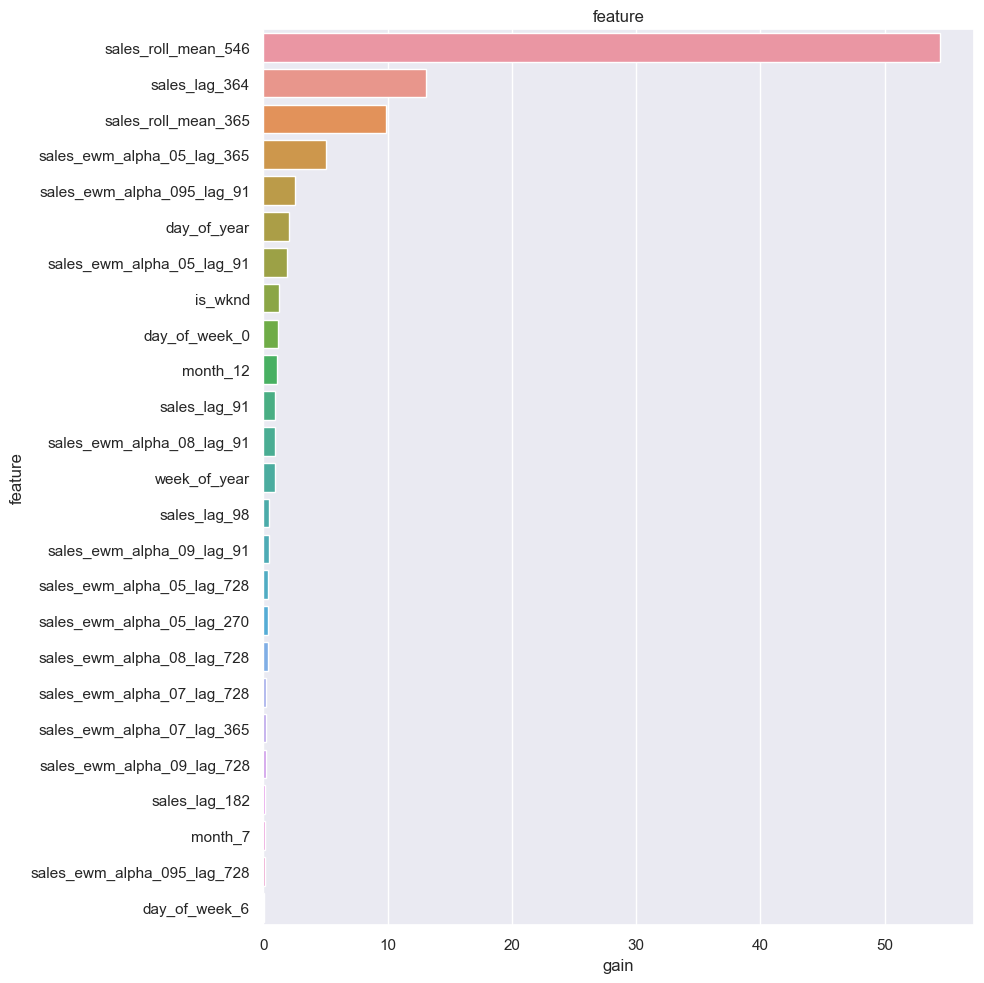

,feature,split,gain
17,sales_roll_mean_546,955,54.460850
13,sales_lag_364,1254,13.108269
16,sales_roll_mean_365,633,9.867018
60,sales_ewm_alpha_05_lag_365,380,5.080150
18,sales_ewm_alpha_095_lag_91,82,2.566262
...,...,...,...
104,item_32,0,0.000000
105,item_33,0,0.000000
107,item_35,0,0.000000
78,item_6,0,0.000000


In [267]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

plot_lgb_importances(model, num=30, plot=True)

In [268]:
feat_imp = plot_lgb_importances(model, num=200)


                        feature  split       gain
17          sales_roll_mean_546    955  54.460850
13                sales_lag_364   1254  13.108269
16          sales_roll_mean_365    633   9.867018
60   sales_ewm_alpha_05_lag_365    380   5.080150
18   sales_ewm_alpha_095_lag_91     82   2.566262
..                          ...    ...        ...
104                     item_32      0   0.000000
105                     item_33      0   0.000000
107                     item_35      0   0.000000
78                       item_6      0   0.000000
71                      store_9      0   0.000000

[142 rows x 3 columns]


In [269]:
importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values


In [270]:
imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

112

### Final Model

In [271]:
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

In [272]:
test = df.loc[df.sales.isna()]
X_test = test[cols]

In [273]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

In [274]:
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)


In [275]:
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [284]:
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

In [287]:
print(test_preds)

[2.54973113 2.76807772 2.70743468 ... 4.36481395 4.40854956 4.47391607]
